In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import string
import contractions as con
from nltk.tokenize import TreebankWordTokenizer
from tqdm import tqdm

from transformer_model import Transformer
import tensorflow as tf
from tensorflow.keras.layers import Input

tk = TreebankWordTokenizer()

In [2]:
# stack all the data and shuffle

df1 = pd.read_csv('train.csv')[['text','headlines']]
df2 = pd.read_csv('news_summary.csv',encoding='latin-1')[['text','headlines']]
df3 = pd.read_csv('news_summary_2.csv')[['text','headlines']]

df = pd.concat([df2,df3,df1],axis=0)
df = df.sample(frac=1).reset_index(drop=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143442 entries, 0 to 143441
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       143442 non-null  object
 1   headlines  143442 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


In [3]:
def clean_text(text):
    
    # fix contractions and remove URLs
    text = [con.fix(w) for w in text.split()]
    text = ' '.join(text).lower()
    url_pattern = r'http\S+|www\S+'
    text = re.sub(url_pattern, '', text)
    
    # remove punctuations other than , . : and provide space 
    punct = string.punctuation.replace('.','').replace(',','').replace(':','')
    translation_table = str.maketrans(punct, ' ' * len(punct))
    result_string = text.translate(translation_table)
    text = re.sub(r'\s+', ' ', result_string)
    text = tk.tokenize(text)
    text = ' '.join(text)
    text = re.sub(r'([!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', text)
    return text.replace(" s "," 's ")

In [4]:
print('Original Text:',df.text[0])
print()
print('Cleaned Text:',clean_text(df.text[0]))

Original Text: New Zealand police have investigated several instances of thieves using Facebook to sell stolen avocados after police began patrolling fruit shops. The police said, "We are seeing thousands of dollars of fruit stolen in a single hit... we take it very seriously." The police said the "avocado crime-wave" had recently escalated, adding, "orchardists have been a lot more vigilant."

Cleaned Text: new zealand police have investigated several instances of thieves using facebook to sell stolen avocados after police began patrolling fruit shops .  the police said  ,  we are seeing thousands of dollars of fruit stolen in a single hit  .  .  .  we take it very seriously .  the police said the avocado crime wave had recently escalated  ,  adding  ,  orchardists have been a lot more vigilant  . 


In [5]:
print('Original Summary:',df.headlines[0])
print()
print('Cleaned Summary:',clean_text(df.headlines[0]))

Original Summary: New Zealand thieves selling stolen avocados on Facebook

Cleaned Summary: new zealand thieves selling stolen avocados on facebook


In [6]:
# clean summary and text

df['clean_text'] = df.text.apply(lambda x: clean_text(x))
df['clean_headlines'] = df.headlines.apply(lambda x: clean_text(x))

In [7]:
# create vocabulary class

class Vocabulary:
    def __init__(self):
        self.special_toks = ['<pad>','<unk>','<sos>','<eos>']
        self.w2i = {'<pad>':0,'<unk>':1,'<sos>':2,'<eos>':3}
        self.i2w = {self.w2i[k]:k for k in self.w2i}
        self.size = len(self.special_toks)
        self.wc = {}
        
    def __call__(self,text):
        
        for sent in text:
            words = sent.split()
            for w in words:
                if w not in self.w2i:
                    self.w2i[w] = self.size
                    self.i2w[self.size] = w
                    self.size += 1
                    
                    self.wc[w] = 1
                    
                elif w not in self.special_toks:
                    self.wc[w] += 1
                    
        self.wc = dict(sorted(self.wc.items(), key=lambda x: x[1], reverse=True))
        
    def tokenize(self,seq):
        seq = seq.split()
        for i,w in enumerate(seq):
            if w not in self.w2i:
                seq[i] = 1
            else:
                seq[i] = self.w2i[w]
                
        return seq
                
    def add_padding(self,seq,maxlen):
        padding = [0]*(maxlen - len(seq))
        return seq + padding

In [8]:
df.drop_duplicates('clean_headlines',inplace=True)

In [10]:
# get maxlens
xmax = max([len(x.split()) for x in df.clean_text]) + 2
ymax = max([len(x.split()) for x in df.clean_headlines]) + 2
xmax,ymax

(114, 25)

In [11]:
# split train and test data

train_size = 110000

xtrain = df.clean_text[:train_size]
xtest = df.clean_text[train_size:]

ytrain = df.clean_headlines[:train_size]
ytest = df.clean_headlines[train_size:]

xvocab = Vocabulary()
xvocab(xtrain.tolist())

yvocab = Vocabulary()
yvocab(ytrain.tolist())

train_en_in = [[2]+xvocab.tokenize(x)+[3] for x in xtrain]
train_dec_in = [[2]+yvocab.tokenize(x)+[3] for x in ytrain]

test_en_in = [[2]+xvocab.tokenize(x)+[3] for x in xtest]
test_dec_in = [[2]+yvocab.tokenize(x)+[3] for x in ytest]

train_en_in = np.asarray([xvocab.add_padding(x,xmax) for x in train_en_in])
train_dec_in = np.asarray([yvocab.add_padding(x,ymax) for x in train_dec_in])

test_en_in = np.asarray([xvocab.add_padding(x,xmax) for x in test_en_in])
test_dec_in = np.asarray([yvocab.add_padding(x,ymax) for x in test_dec_in])



In [12]:
train_en_in[-1],train_dec_in[-1]

(array([    2,    34,   155,   672,   401,  1114,   666,  2501, 31766,
         1793,    99,  1932,   763,  7210,   153,  3609,  3297,    24,
          552,    11,    25, 31766,   582,   212,   213, 12954,    15,
           25,  2508,  1686,   229,    25,   823,   192, 11247,    24,
         1558,    15,    25,   155,    34,   591,  1562,  1085,    27,
         2501,  1133,   212,  6101,   266,  1053,    24,    24,    24,
        14751,  2501,   211,   494,  5454,    24,    38,   553,   212,
         1197,    24,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([    2,    44,  2373,  4490,   845, 14670,  5134,    10,   654,
            3,     0,    

In [13]:
# define parameters and build transformer model

d_model = 128
units = d_model * 4
heads = 8
en_vocab_size = xvocab.size
dec_vocab_size = yvocab.size
batch = 64
num_layers = 4

model = Transformer(d_model=d_model,ff_units=units,n_heads=heads,maxlen=xmax,en_vocab_size=en_vocab_size,
                    dec_vocab_size=dec_vocab_size,en_layers=num_layers,dec_layers=num_layers)

en_in = Input((xmax,),batch_size=batch)
dec_in = Input((ymax,),batch_size=batch)

model.build([en_in.shape,dec_in.shape])

model.summary([en_in,dec_in])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(64, 114)]          0           []                               
                                                                                                  
 positional_word_embedding_2 (P  ((64, 114, 128),    11340800    ['input_1[0][0]']                
 ositionalWordEmbedding)         (64, 114))                                                       
                                                                                                  
 encoder_4 (Encoder)            (64, 114, 128)       198272      ['positional_word_embedding_2[0][
                                                                 0]',                             
                                                                  'positional_word_embedding_2

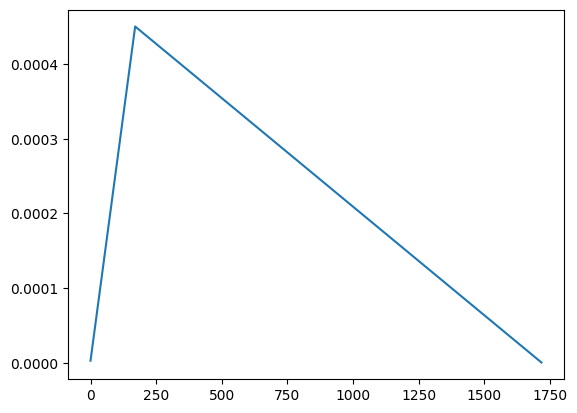

In [14]:
# initialise loss, optimizer and lr scheduler

opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

class CustomLRScheduler:
    def __init__(self,emb_size,end_lr,total_steps):
        self.emb_size = emb_size**-0.5
        self.end = end_lr
        self.total = total_steps
        self.warmup = total_steps//10
        self.decay = total_steps - self.warmup
        self.max = None
    
    def __call__(self,step):
        
        if step<=self.warmup:
            incr_rate = step*self.warmup**-1.5
            self.max = self.emb_size*incr_rate/15
            return self.emb_size*incr_rate/15
        else:
            step -= self.warmup
            lr_diff = self.max - self.end
            decay_rate = (1-step/self.decay) ** 1
            return lr_diff * decay_rate + self.end
        
end_lr = 0.0
emb_size = d_model
total_steps = len(xtrain)//batch
        
lr_scheduler = CustomLRScheduler(128,0.0,total_steps+1)

plt.plot([lr_scheduler(x) for x in range(1,total_steps+1)])

In [15]:
# convert data to tf tensors

train = tf.data.Dataset.from_tensor_slices((train_en_in,train_dec_in))
train = train.batch(batch_size=batch, drop_remainder=True).shuffle(buffer_size=1000)

test = tf.data.Dataset.from_tensor_slices((test_en_in,test_dec_in))
test = test.batch(batch_size=batch, drop_remainder=True).shuffle(buffer_size=1000)

In [16]:
# define train step  and test step

@tf.function
def train_step(x,y):
    tar_in = y[:,:-1]
    tar_out = y[:,1:]
    with tf.GradientTape() as tape:
        pred = model([x,tar_in],training=True)
        loss = loss_fn(tar_out,pred,sample_weight=tar_out>0)
    weights = model.trainable_weights
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return loss

@tf.function
def test_step(x,y):
    tar_in = y[:,:-1]
    tar_out = y[:,1:]
    pred = model([x,tar_in],training=False)
    loss = loss_fn(tar_out,pred,sample_weight=tar_out>0)
    return loss
    
    

In [17]:
# create training loop

epochs = 10
losses = {'train':[],'val':[]}
for e in range(1,epochs+1):
    print(f'{e}/{epochs}')
    
    loss = 0
    
    # run train step 
    for i,(x,y) in enumerate(tqdm(train)):
        # get lr for current step and assign
        lr = lr_scheduler(float(i+1)) 
        opt.learning_rate.assign(lr)
        loss += train_step(x,y)
    
    # save training loss
    loss = loss.numpy()/i
    print('train loss :',round(loss,4))
    losses['train'].append(loss)
    
    
    loss = 0
    
    # run test step
    for i,(x,y) in enumerate(test):
        loss += test_step(x,y)
    
    loss = loss.numpy()/i
    print('val loss :',round(loss,4))
    
    # input example to monitor performance after every epoch
    inp = np.expand_dims(test_en_in[0],0)
    yin = tf.cast([[2]],dtype=tf.int32)
    out = []
    for i in range(20):
        pred = model([inp,yin]).numpy()
        pred = tf.cast(np.argmax(pred[:,-1:,:],axis=-1),dtype=tf.int32)
        if pred[0][0] == 3:
            break
        out.append(pred[0][0].numpy())
        yin = tf.concat([yin,tf.expand_dims(pred[0],axis=0)],axis=1)
    print()
    print('Text :',' '.join([xvocab.i2w[t] for t in test_en_in[0] if t>0]))
    print()
    print('Acutal Summary :',' '.join([yvocab.i2w[t] for t in test_dec_in[0] if t>0]))
    print()
    print('Predicted Summary :',' '.join([yvocab.i2w[t] for t in out]))
    print('-------------------------------------------------------------')
    
    
    # save best weights
    if e == 1:
        model.save_weights('weights.h5')
        print('best weights saved')
    elif loss < min(losses['val']):
        model.save_weights('weights.h5')
        print('best weights saved')
        
    losses['val'].append(loss)
    print()
    

1/10


100%|██████████████████████████████████████████████████████████████████████████████| 1718/1718 [03:23<00:00,  8.44it/s]


train loss : 3.3932
val loss : 2.9805

Text : <sos> actor aditya pancholi and his wife zarina wahab have sent a legal notice citing defamation to kangana ranaut 's sister rangoli . aditya had recently said , rangoli has tweeted a lot of objectionable stuff against my wife , daughter and son . which is why , i am taking the legal recourse against her . earlier , they had also sent a similar legal notice to kangana . <eos>

Acutal Summary : <sos> aditya , wife send defamation notice to kangana 's sister <eos>

Predicted Summary : i am not be : ex ex ex ex ex ex ex ex ex ex ex ex ex ex ex
-------------------------------------------------------------
best weights saved

2/10


100%|██████████████████████████████████████████████████████████████████████████████| 1718/1718 [03:21<00:00,  8.54it/s]


train loss : 2.7181
val loss : 2.5038

Text : <sos> actor aditya pancholi and his wife zarina wahab have sent a legal notice citing defamation to kangana ranaut 's sister rangoli . aditya had recently said , rangoli has tweeted a lot of objectionable stuff against my wife , daughter and son . which is why , i am taking the legal recourse against her . earlier , they had also sent a similar legal notice to kangana . <eos>

Acutal Summary : <sos> aditya , wife send defamation notice to kangana 's sister <eos>

Predicted Summary : salman , salman , wife get notice to kangana 's son 's son
-------------------------------------------------------------
best weights saved

3/10


100%|██████████████████████████████████████████████████████████████████████████████| 1718/1718 [03:23<00:00,  8.42it/s]


train loss : 2.3025
val loss : 2.1948

Text : <sos> actor aditya pancholi and his wife zarina wahab have sent a legal notice citing defamation to kangana ranaut 's sister rangoli . aditya had recently said , rangoli has tweeted a lot of objectionable stuff against my wife , daughter and son . which is why , i am taking the legal recourse against her . earlier , they had also sent a similar legal notice to kangana . <eos>

Acutal Summary : <sos> aditya , wife send defamation notice to kangana 's sister <eos>

Predicted Summary : sonam , wife quit kangana 's wife for sexual harassment
-------------------------------------------------------------
best weights saved

4/10


100%|██████████████████████████████████████████████████████████████████████████████| 1718/1718 [03:24<00:00,  8.39it/s]


train loss : 1.9844
val loss : 1.9962

Text : <sos> actor aditya pancholi and his wife zarina wahab have sent a legal notice citing defamation to kangana ranaut 's sister rangoli . aditya had recently said , rangoli has tweeted a lot of objectionable stuff against my wife , daughter and son . which is why , i am taking the legal recourse against her . earlier , they had also sent a similar legal notice to kangana . <eos>

Acutal Summary : <sos> aditya , wife send defamation notice to kangana 's sister <eos>

Predicted Summary : aditya , wife , wife sent to kangana 's defamation notice to kangana
-------------------------------------------------------------
best weights saved

5/10


100%|██████████████████████████████████████████████████████████████████████████████| 1718/1718 [03:25<00:00,  8.36it/s]


train loss : 1.735
val loss : 1.8732

Text : <sos> actor aditya pancholi and his wife zarina wahab have sent a legal notice citing defamation to kangana ranaut 's sister rangoli . aditya had recently said , rangoli has tweeted a lot of objectionable stuff against my wife , daughter and son . which is why , i am taking the legal recourse against her . earlier , they had also sent a similar legal notice to kangana . <eos>

Acutal Summary : <sos> aditya , wife send defamation notice to kangana 's sister <eos>

Predicted Summary : aditya , wife aditya sends legal notice to kangana over defamation case
-------------------------------------------------------------
best weights saved

6/10


100%|██████████████████████████████████████████████████████████████████████████████| 1718/1718 [03:25<00:00,  8.36it/s]


train loss : 1.5327
val loss : 1.8041

Text : <sos> actor aditya pancholi and his wife zarina wahab have sent a legal notice citing defamation to kangana ranaut 's sister rangoli . aditya had recently said , rangoli has tweeted a lot of objectionable stuff against my wife , daughter and son . which is why , i am taking the legal recourse against her . earlier , they had also sent a similar legal notice to kangana . <eos>

Acutal Summary : <sos> aditya , wife send defamation notice to kangana 's sister <eos>

Predicted Summary : aditya pancholi , wife sent legal notice to kangana 's sister
-------------------------------------------------------------
best weights saved

7/10


100%|██████████████████████████████████████████████████████████████████████████████| 1718/1718 [03:26<00:00,  8.32it/s]


train loss : 1.3617
val loss : 1.7737

Text : <sos> actor aditya pancholi and his wife zarina wahab have sent a legal notice citing defamation to kangana ranaut 's sister rangoli . aditya had recently said , rangoli has tweeted a lot of objectionable stuff against my wife , daughter and son . which is why , i am taking the legal recourse against her . earlier , they had also sent a similar legal notice to kangana . <eos>

Acutal Summary : <sos> aditya , wife send defamation notice to kangana 's sister <eos>

Predicted Summary : aditya pancholi , wife send legal notice to kangana 's sister
-------------------------------------------------------------
best weights saved

8/10


100%|██████████████████████████████████████████████████████████████████████████████| 1718/1718 [03:26<00:00,  8.33it/s]


train loss : 1.214
val loss : 1.7679

Text : <sos> actor aditya pancholi and his wife zarina wahab have sent a legal notice citing defamation to kangana ranaut 's sister rangoli . aditya had recently said , rangoli has tweeted a lot of objectionable stuff against my wife , daughter and son . which is why , i am taking the legal recourse against her . earlier , they had also sent a similar legal notice to kangana . <eos>

Acutal Summary : <sos> aditya , wife send defamation notice to kangana 's sister <eos>

Predicted Summary : aditya pancholi , wife aditya sent legal notice to kangana
-------------------------------------------------------------
best weights saved

9/10


100%|██████████████████████████████████████████████████████████████████████████████| 1718/1718 [03:26<00:00,  8.31it/s]


train loss : 1.0883
val loss : 1.7761

Text : <sos> actor aditya pancholi and his wife zarina wahab have sent a legal notice citing defamation to kangana ranaut 's sister rangoli . aditya had recently said , rangoli has tweeted a lot of objectionable stuff against my wife , daughter and son . which is why , i am taking the legal recourse against her . earlier , they had also sent a similar legal notice to kangana . <eos>

Acutal Summary : <sos> aditya , wife send defamation notice to kangana 's sister <eos>

Predicted Summary : aditya pancholi , wife send legal notice to kangana ranaut
-------------------------------------------------------------

10/10


100%|██████████████████████████████████████████████████████████████████████████████| 1718/1718 [03:26<00:00,  8.32it/s]


train loss : 0.9758
val loss : 1.7999

Text : <sos> actor aditya pancholi and his wife zarina wahab have sent a legal notice citing defamation to kangana ranaut 's sister rangoli . aditya had recently said , rangoli has tweeted a lot of objectionable stuff against my wife , daughter and son . which is why , i am taking the legal recourse against her . earlier , they had also sent a similar legal notice to kangana . <eos>

Acutal Summary : <sos> aditya , wife send defamation notice to kangana 's sister <eos>

Predicted Summary : aditya pancholi , wife read legal notice to kangana ranaut
-------------------------------------------------------------



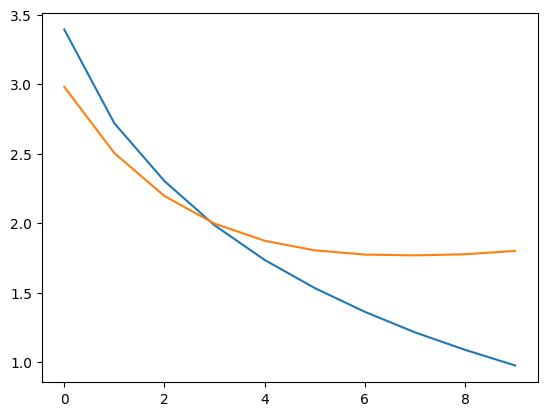

In [18]:
# plot training logs

plt.plot(losses['train'])
plt.plot(losses['val'])
plt.show()

In [19]:
# load the best weights
model.load_weights('weights.h5')

actor aditya pancholi and his wife zarina wahab have sent a legal notice citing defamation to kangana ranaut 's sister rangoli . aditya had recently said , rangoli has tweeted a lot of objectionable stuff against my wife , daughter and son . which is why , i am taking the legal recourse against her . earlier , they had also sent a similar legal notice to kangana .

aditya pancholi , wife aditya sent legal notice to kangana

aditya , wife send defamation notice to kangana 's sister


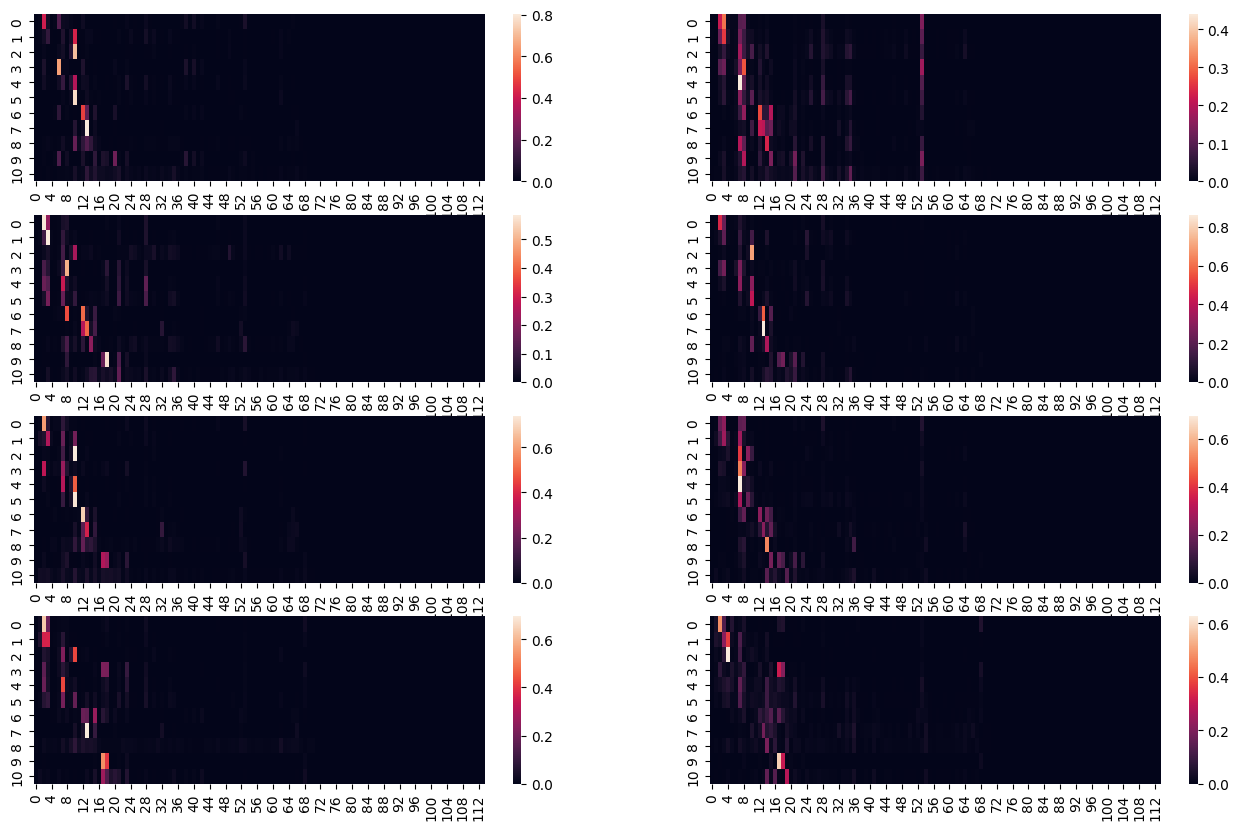

-------------------------------------------------------------------------------------------


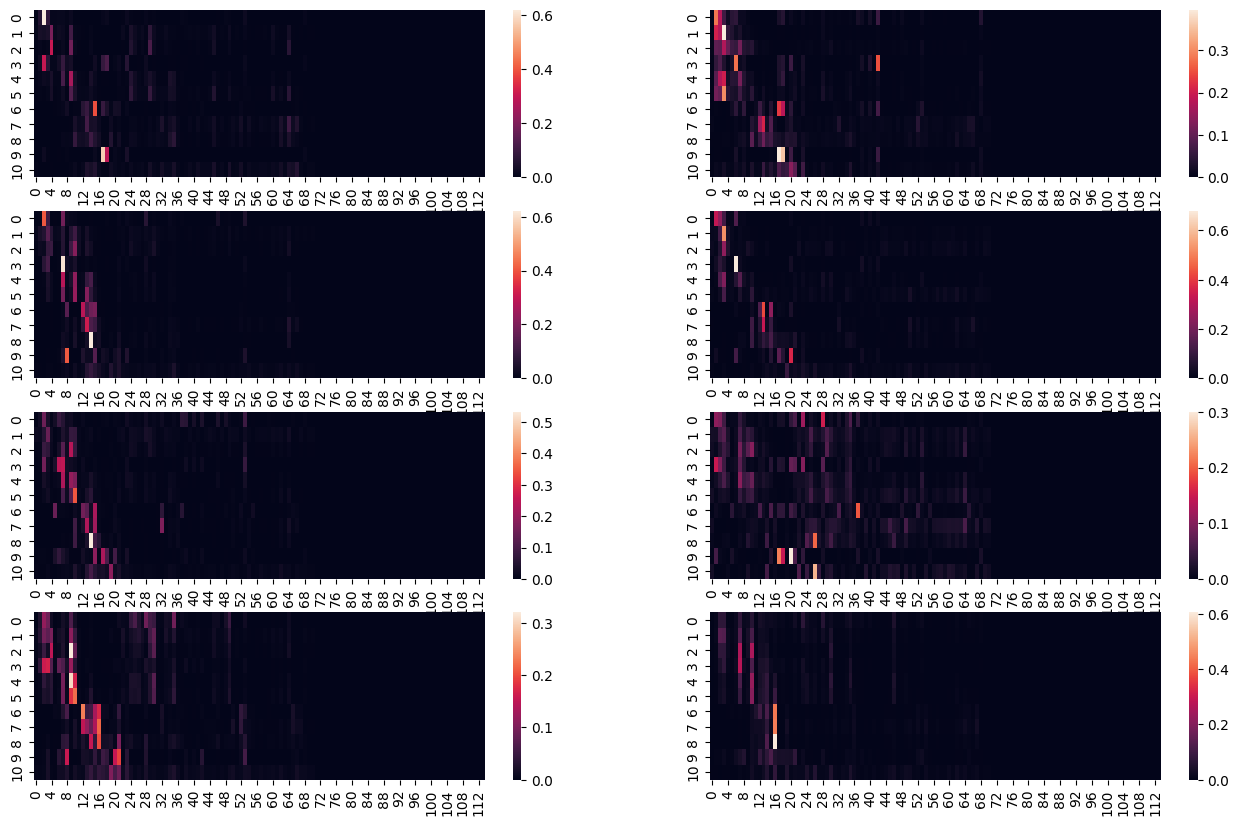

-------------------------------------------------------------------------------------------


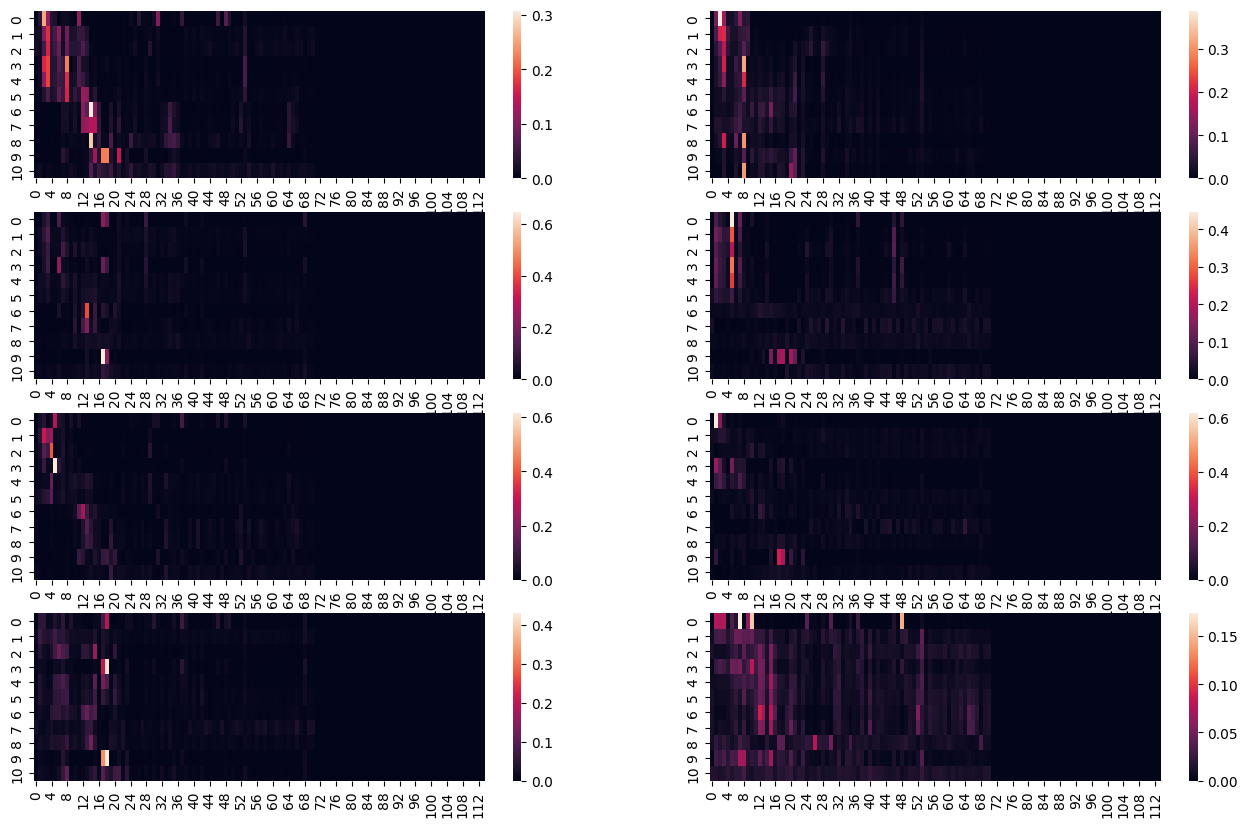

-------------------------------------------------------------------------------------------


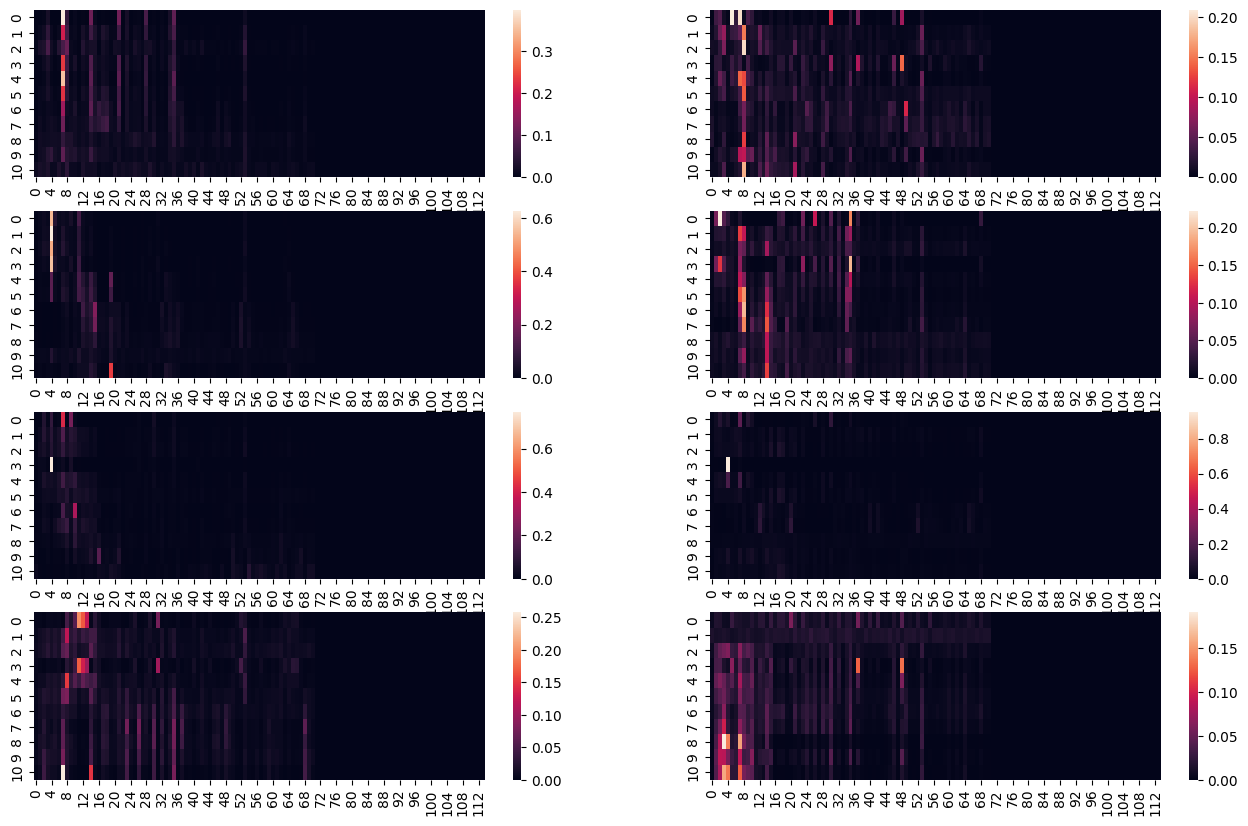

-------------------------------------------------------------------------------------------


In [23]:
# plot cross attetion of all the attention head of every decoder layer

import matplotlib.pyplot as plt
import seaborn as sb

idx = 0

inp = np.expand_dims(test_en_in[idx],0)
inp = tf.convert_to_tensor(inp,dtype=tf.int32)
yin = tf.cast([[2]],dtype=tf.int32)
out = []
for i in range(20):
    pred = model([inp,yin]).numpy()
    pred = tf.cast(np.argmax(pred[:,-1:,:],axis=-1),dtype=tf.int32)
    if pred[0][0] == 3:
        break
    out.append(pred[0][0].numpy())
    yin = tf.concat([yin,tf.expand_dims(pred[0],axis=0)],axis=1)


print(' '.join(xvocab.i2w[x] for x in test_en_in[idx] if x>3))
print()
print(' '.join(yvocab.i2w[x] for x in out))
print()
print(' '.join(yvocab.i2w[x] for x in test_dec_in[idx] if x>3))

for idx in range(2,6):

    _,ax = plt.subplots(4,2,figsize=(16,10))

    attn = model.layers[-idx].mhca.attention_scores[0]
    maxlen = xmax
    attn

    for i in range(4):
        for j in range(2):
            sb.heatmap(np.reshape(attn,
                                  (4,2,len(out)+1,xmax))[i][j],ax=ax[i][j])
    plt.show()
            
    print('-------------------------------------------------------------------------------------------')

In [27]:
# inference using beam search decoding

from beam_search import BeamSearchDecoder

bsd = BeamSearchDecoder(model,x_vocab=xvocab,y_vocab=yvocab)

data = df[train_size:].reset_index(drop=True)
idx = np.random.randint(0,len(data)-1,15)
for i in idx:
    try:
        text = df.text[i]
        bsd(text)
        print('Text :',text)
        print()
        print('Actual summary :',df.headlines[i])
        print()

        print('Predn with beam width 1 :',bsd.summarize(k=1,alpha=0.8)[0][0])
        print('Predn with beam width 5 :',bsd.summarize(k=5,alpha=0.8)[0][0])
        print('Predn with beam width 100 :',bsd.summarize(k=100,alpha=0.8)[0][0])
        print('-----------------------------------------------------------------------------------\n')
    except:
        pass

Text : Financial Services Secretary Rajiv Kumar has said the government won't allow any state-run bank to default and will provide capital support. "Even if there is a loss for one or two quarters, it is okay...We are ready to take this," Kumar added. He further said banks are getting cleaned up and bad loans are being recognised in a transparent manner. 

Actual summary : Government won't allow any bank to fail: Finance Ministry

Predn with beam width 1 : <sos> no state run state run banks to be default : govt <eos>
Predn with beam width 5 : <sos> will not allow any state bank to support any capital : govt <eos>
Predn with beam width 100 : <sos> will not allow any state bank to support any capital : rajiv kumar <eos>
-----------------------------------------------------------------------------------

Text : Scientists have unearthed two fossils in Italy and Japan, belonging to a whale species which is known to live in the Southern Hemisphere for the past 10 million years. The fossils 

Predn with beam width 1 : <sos> you want you love : sunny to husband on 40th birthday <eos>
Predn with beam width 5 : <sos> you want my life : sunny wishes husband on 40th birthday <eos>
Predn with beam width 100 : <sos> you want my life : sunny wishes husband on 40th b day <eos>
-----------------------------------------------------------------------------------

Text : After Nawaz Sharif said that militant organisations based in Pakistan were responsible for the 26/11 Mumbai terror attacks, his political party PML-N stated that the former Prime Minister's statement had been "grossly misinterpreted". It further said that Sharif needs no certificate from anybody on his commitment and capacity to preserve, protect and promote Pakistan's national security.

Actual summary : Sharif's 26/11 statement 'grossly misinterpreted': Party

Predn with beam width 1 : <sos> ex pak security council calls for 26 11 terror attacks : bjp <eos>
Predn with beam width 5 : <sos> sharif 's statement grossly m